# GENSIM TOPIC MODELING 

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is **how to extract good quality of topics** that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

Contents
1. Introduction
2. Prerequisites – Download nltk stopwords and spacy model
3. Import Packages
4. What does LDA do?
5. Prepare Stopwords
6. Import Newsgroups Data
7. Remove emails and newline characters
8. Tokenize words and Clean-up text
9. Creating Bigram and Trigram Models
10. Remove Stopwords, Make Bigrams and Lemmatize
11. Create the Dictionary and Corpus needed for Topic Modeling
12. Building the Topic Model
13. View the topics in LDA model
14. Compute Model Perplexity and Coherence Score
15. Visualize the topics-keywords
16. Building LDA Mallet Model
17. How to find the optimal number of topics for LDA?
18. Finding the dominant topic in each sentence
19. Find the most representative document for each topic
20. Topic distribution across documents

## 1. Introduction

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

## 2. Prerequisites – Download nltk stopwords and spacy model

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

In [1]:
# Run in python console
#import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

## 3. Import Packages

The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 4. What does LDA do?

**LDA’s** approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

1. The quality of text processing.
2. The variety of topics the text talks about.
3. The choice of topic modeling algorithm.
4. The number of topics fed to the algorithm.
5. The algorithms tuning parameters.

## 5. Prepare Stopwords

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## 6. Import Newsgroups Data

We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. 

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## 7. Remove emails and newline characters

In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

## 8. Tokenize words and Clean-up text## 

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## 9. Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## 10. Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Let’s call the functions in order.

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood']]


## 11. Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of **(word_id, word_frequency)**

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [12]:
id2word[0]

'addition'

In [13]:
# Or, you can see a human-readable form of the corpus itself.
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

## 12. Building the Topic Model

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

## 13. View the topics in LDA model

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"line" + 0.035*"thank" + 0.033*"host" + 0.025*"mail" + 0.022*"send" + '
  '0.018*"list" + 0.017*"post" + 0.016*"new" + 0.016*"price" + 0.016*"buy"'),
 (1,
  '0.821*"ax" + 0.059*"max" + 0.012*"signal" + 0.009*"circuit" + 0.006*"noise" '
  '+ 0.005*"mph" + 0.005*"receiver" + 0.004*"voltage" + 0.003*"preferably" + '
  '0.003*"accuracy"'),
 (2,
  '0.100*"space" + 0.036*"launch" + 0.031*"earth" + 0.029*"project" + '
  '0.027*"development" + 0.026*"orbit" + 0.023*"satellite" + 0.022*"ground" + '
  '0.022*"mission" + 0.021*"unit"'),
 (3,
  '0.033*"year" + 0.027*"time" + 0.021*"day" + 0.020*"back" + 0.017*"last" + '
  '0.016*"end" + 0.014*"go" + 0.014*"take" + 0.014*"power" + 0.013*"leave"'),
 (4,
  '0.155*"press" + 0.054*"pitch" + 0.043*"specification" + 0.040*"derive" + '
  '0.034*"phase" + 0.030*"qualified" + 0.020*"pure" + 0.018*"retrieve" + '
  '0.016*"loop" + 0.010*"manifest"'),
 (5,
  '0.111*"die" + 0.081*"israeli" + 0.075*"drug" + 0.074*"war" + 0.046*"trial" '
  '+ 0.044*

**How to interpret this?**

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

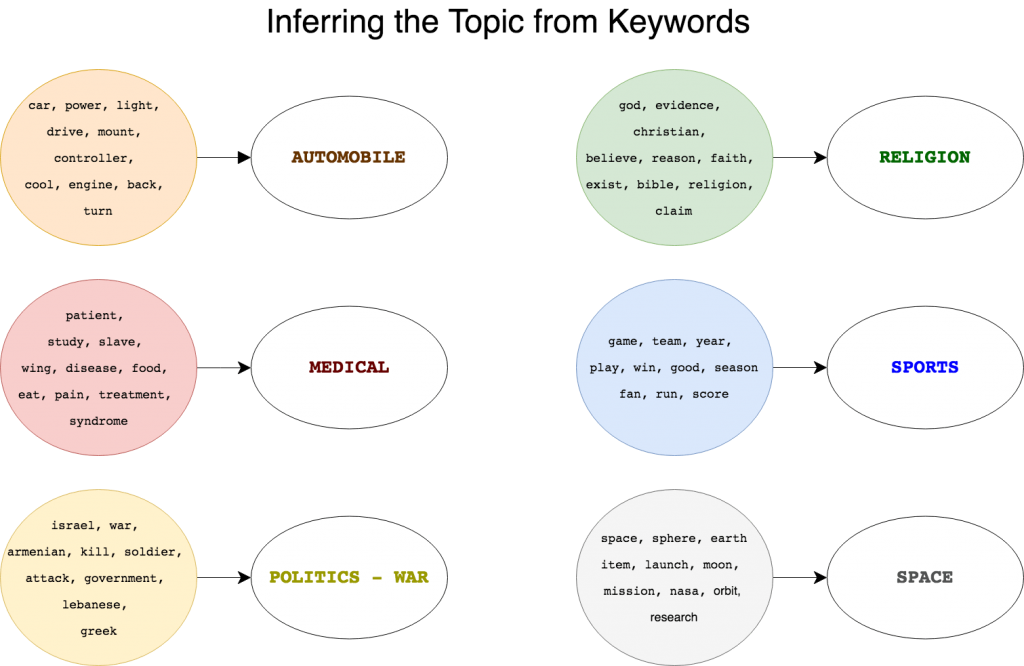

In [19]:
from IPython.display import Image
Image(filename='Inferring-Topic.png', width=800, height=800)

## 14. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.909670001515828

Coherence Score:  0.4877875897455026


## 15. Visualize the topics-keywords

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.297367  0.112060       1        1  25.349499
17     0.238977 -0.002741       2        1  12.172510
7      0.260862  0.154927       3        1  10.636918
3      0.197471  0.025498       4        1  10.175332
19     0.187939 -0.217021       5        1   9.252839
0      0.158938 -0.227807       6        1   7.205372
14     0.165707  0.218625       7        1   6.568269
1     -0.049719  0.002925       8        1   5.521766
16     0.001630 -0.008106       9        1   2.960415
13     0.013748 -0.176824      10        1   2.073586
6     -0.108094  0.014428      11        1   1.512327
10    -0.086314 -0.115043      12        1   1.340652
2     -0.096878 -0.090371      13        1   1.174213
8     -0.081079  0.047767      14        1   1.002041
11    -0.148939  0.046106      15        1   0.784568
15    -0.170490  0.033384      16        1   0.638251
5     -0.165237  0.050372      17        1   0.632632
12    -0.188495  0.040569      18        1   0.489576
18    -0.203238  0.046336      19        1   0.350692
4     -0.224158  0.044916      20        1   0.158546, topic_info=              Term          Freq         Total Category  logprob  loglift
3483            ax  52279.000000  52279.000000  Default  30.0000  30.0000
166          would  15711.000000  15711.000000  Default  29.0000  29.0000
17            line  10436.000000  10436.000000  Default  28.0000  28.0000
187          write  13150.000000  13150.000000  Default  27.0000  27.0000
131         people   7756.000000   7756.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
3140      internet      0.034740      1.316420  Topic20 -10.8706   2.8121
5169         greek      0.034739      1.316335  Topic20 -10.8706   2.8121
5143  announcement      0.034739      1.316348  Topic20 -10.8706   2.8121
3167         slave      0.034740      1.316405  Topic20 -10.8706   2.8121
3236        chance      0.034739      1.316391  Topic20 -10.8706   2.8121

[874 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
785       9  0.195128      abuse
785      10  0.798665      abuse
1172      1  0.039620     accept
1172      2  0.288399     accept
1172      7  0.671703     accept
...     ...       ...        ...
39       14  0.113455       year
702      17  0.993387  yesterday
554       7  0.989366      young
554      18  0.008420      young
555      18  0.948175  youve_got

[1171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 18, 8, 4, 20, 1, 15, 2, 17, 14, 7, 11, 3, 9, 12, 16, 6, 13, 19, 5])

**So how to infer pyLDAvis’s output?**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

## 16. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet.

In [42]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#import os
#os.environ.update({'MALLET_HOME': r'C:/Users/alexa/mallet-2.0.8/'})

mallet_path = 'C:/Users/alexa/mallet-2.0.8/bin/mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [43]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('buy', 0.02818859815446846),
   ('good', 0.027177347996460623),
   ('price', 0.024295285046138287),
   ('sell', 0.02318290987232967),
   ('make', 0.02285425357097712),
   ('work', 0.021059284540513208),
   ('pay', 0.02042725319175831),
   ('cost', 0.018783971684995574),
   ('money', 0.017798002780937936),
   ('lot', 0.014536721021362659)]),
 (19,
  [('line', 0.031809093505751604),
   ('image', 0.028225701747552647),
   ('color', 0.02157825037002415),
   ('bit', 0.018020825218768664),
   ('graphic', 0.014800965957778297),
   ('point', 0.013684401859209057),
   ('write', 0.013606502038378645),
   ('time', 0.012931370257848407),
   ('find', 0.012515904546752875),
   ('draw', 0.009997143673236219)]),
 (5,
  [('space', 0.020720341797091184),
   ('launch', 0.009762468731321807),
   ('project', 0.009585371792885131),
   ('system', 0.009297589267925531),
   ('year', 0.007393797179731256),
   ('base', 0.007260974475903748),
   ('design', 0.007061740420162487),
   ('program', 0.0070396

## 17. How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
%%time

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Wall time: 14min 59s


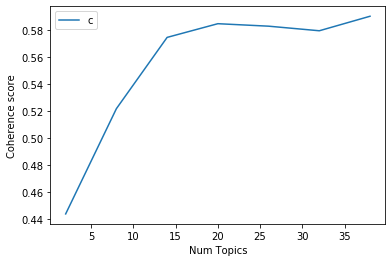

In [46]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4438
Num Topics = 8  has Coherence Value of 0.5219
Num Topics = 14  has Coherence Value of 0.5748
Num Topics = 20  has Coherence Value of 0.585
Num Topics = 26  has Coherence Value of 0.5831
Num Topics = 32  has Coherence Value of 0.5797
Num Topics = 38  has Coherence Value of 0.5905


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [48]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.043*"key" + 0.019*"system" + 0.015*"encryption" + 0.014*"chip" + '
  '0.013*"government" + 0.012*"bit" + 0.012*"technology" + 0.012*"public" + '
  '0.012*"message" + 0.011*"security"'),
 (1,
  '0.015*"people" + 0.014*"man" + 0.013*"word" + 0.010*"church" + 0.010*"make" '
  '+ 0.010*"love" + 0.008*"world" + 0.008*"christian" + 0.007*"day" + '
  '0.007*"life"'),
 (2,
  '0.013*"drug" + 0.010*"study" + 0.009*"problem" + 0.009*"food" + '
  '0.009*"doctor" + 0.008*"effect" + 0.008*"day" + 0.008*"patient" + '
  '0.007*"eat" + 0.007*"disease"'),
 (3,
  '0.027*"gun" + 0.021*"law" + 0.019*"state" + 0.017*"people" + 0.013*"case" + '
  '0.010*"crime" + 0.010*"weapon" + 0.009*"make" + 0.009*"person" + '
  '0.008*"police"'),
 (4,
  '0.032*"mail" + 0.029*"post" + 0.027*"send" + 0.022*"list" + 0.021*"group" + '
  '0.020*"information" + 0.018*"address" + 0.015*"internet" + 0.014*"include" '
  '+ 0.014*"message"'),
 (5,
  '0.019*"question" + 0.018*"claim" + 0.017*"reason" + 0.016*"exist" + '
 

## 18. Finding the dominant topic in each sentence

In [49]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.1758,"car, buy, good, bike, price, ride, sell, back,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,10.0,0.1386,"drive, card, system, problem, driver, work, di...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,10.0,0.1099,"drive, card, system, problem, driver, work, di...",From: (Thomas E Willis) Subject: PB questions....
3,3,13.0,0.1162,"write, article, organization, line, opinion, r...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,18.0,0.1691,"file, program, line, change, read, set, follow...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,3.0,0.2988,"gun, law, state, people, case, crime, weapon, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,4.0,0.1250,"mail, post, send, list, group, information, ad...",From: (brian manning delaney) Subject: Brain T...
7,7,10.0,0.3882,"drive, card, system, problem, driver, work, di...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,18.0,0.0959,"file, program, line, change, read, set, follow...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,10.0,0.1794,"drive, card, system, problem, driver, work, di...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


## 19. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [50]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8461,"key, system, encryption, chip, government, bit...",From: (Clipper Chip Announcement) Subject: tex...
1,1.0,0.6048,"people, man, word, church, make, love, world, ...",From: (Paul Harvey) Subject: Re: Sabbath Admis...
2,2.0,0.6936,"drug, study, problem, food, doctor, effect, da...","From: Subject: Candida(yeast) Bloom, Fact or F..."
3,3.0,0.6556,"gun, law, state, people, case, crime, weapon, ...",Subject: roman.bmp 01/14In response to the req...
4,4.0,0.4952,"mail, post, send, list, group, information, ad...",From: (Peter Kaminski) Subject: Re: Need to fi...


## 20. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information

In [51]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,17.0,"car, buy, good, bike, price, ride, sell, back,...",476.0,0.0421
1.0,10.0,"drive, card, system, problem, driver, work, di...",650.0,0.0575
2.0,10.0,"drive, card, system, problem, driver, work, di...",536.0,0.0474
3.0,13.0,"write, article, organization, line, opinion, r...",552.0,0.0488
4.0,18.0,"file, program, line, change, read, set, follow...",549.0,0.0485
...,...,...,...,...
11309.0,2.0,"drug, study, problem, food, doctor, effect, da...",NaN,NaN
11310.0,8.0,"power, ground, current, wire, work, line, high...",NaN,NaN
11311.0,10.0,"drive, card, system, problem, driver, work, di...",NaN,NaN
11312.0,15.0,"time, point, find, science, problem, work, res...",NaN,NaN
